In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator

### Carga de datos

In [2]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")
# test = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTest.plk")
# docDict = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/UniquePanDocs.plk")

In [3]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [4]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [5]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [6]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [7]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [8]:
labels["a09fdc6b-ed15-48c5-9d2e-572f989b9b4500000"]

0

In [9]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [10]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


In [11]:
train.loc[train.id == 'a'].merge(full_spectra, left_on='idtext', right_on='id').spectra


Series([], Name: spectra, dtype: object)

### Definición de la arquitectura de red siamesa

In [12]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa

x1 = tf.keras.Input(shape=(1200,), name="Input_1")
x2 = tf.keras.Input(shape=(1200,), name="Input_2")

# Batch normalization
bn_layer = tf.keras.layers.BatchNormalization(name="Batch_normalization")
x1 = bn_layer(x1)
x2 = bn_layer(x2)

# Gaussian noise
gaussian_noise_layer = tf.keras.layers.GaussianNoise(1.0, name="Gaussian_noise")
x1 = gaussian_noise_layer(x1)
x2 = gaussian_noise_layer(x2)

# Dropout
dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
x1 = dropout_layer(x1)
x2 = dropout_layer(x2)

# Residual network

substract = lambda x: x[0] - x[1]
residual = tf.keras.layers.Lambda(function=substract, output_shape=lambda x: x[0], name='residual')

dense_layer_1 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_1")
o1_1 = dense_layer_1(x1)
o1_2 = dense_layer_1(x2)

dense_layer_2 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_2")
o2_1 = dense_layer_2(o1_1)
o2_2 = dense_layer_2(o1_2)

# Residual layer
dense_layer_3 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_3")
o3_1 = dense_layer_3(residual([o1_1, o2_1]))
o3_2 = dense_layer_3(residual([o1_2, o2_2]))

dense_layer_4 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_4")
o4_1 = dense_layer_4(o3_1)
o4_2 = dense_layer_4(o3_2)

# Residual layer
dense_layer_5 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_5")
o5_1 = dense_layer_5(residual([o3_1, o4_1]))
o5_2 = dense_layer_5(residual([o3_2, o4_2]))

dense_layer_6 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_6")
o6_1 = dense_layer_6(o5_1)
o6_2 = dense_layer_6(o5_2)

# Residual layer
dense_layer_7 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_7")
o7_1 = dense_layer_7(residual([o5_1, o6_1]))
o7_2 = dense_layer_7(residual([o5_2, o6_2]))

dense_layer_8 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_8")
o8_1 = dense_layer_8(o7_1)
o8_2 = dense_layer_8(o7_2)

# Residual layer
dense_layer_9 = tf.keras.layers.Dense(256, activation='relu', name="ResDense_9")
o9_1 = dense_layer_9(residual([o7_1, o8_1]))
o9_2 = dense_layer_9(residual([o7_2, o8_2]))

# Merging
abs_substract = lambda x: tf.keras.backend.abs(x[0] - x[1])
merge = tf.keras.layers.Lambda(function=abs_substract, output_shape=lambda x: x[0], name='merge')([o9_1,o9_2])

# MLPNN Classifier
hidden = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer")(merge)
dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout_2")(hidden)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

model = tf.keras.Model([x1, x2], output)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 ResDense_1 (Dense)             (None, 256)          307456      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 ResDense_2 (Dense)             (None, 256)          65792       ['ResDense_1[2][0]',             
                                                                  'ResDense_1[3][0]']             
                                                                                              

### Entrenamiento de red siamesa

In [14]:
print("train: ", train.shape[0])
print("test: ", val.shape[0])

train:  31464
test:  1508


In [15]:
print("train: ", train.id.unique().size)
print("test: ", val.id.unique().size)

train:  15732
test:  754


In [16]:
# Parameters
params = {'dim': (1200,),
            'batch_size': 32,
            'shuffle': True}

In [17]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [18]:
# Train model on dataset
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    # use_multiprocessing=True,
                    # workers=4,
                    epochs=100,
                    verbose=1)

Epoch 1/100
491/491 [==============================] - 66s 128ms/step - loss: 1.1693 - binary_accuracy: 0.5321 - val_loss: 0.6991 - val_binary_accuracy: 0.5584
Epoch 2/100
491/491 [==============================] - 60s 122ms/step - loss: 0.6855 - binary_accuracy: 0.5432 - val_loss: 0.6901 - val_binary_accuracy: 0.5217
Epoch 3/100
491/491 [==============================] - 61s 123ms/step - loss: 0.6908 - binary_accuracy: 0.5353 - val_loss: 0.6875 - val_binary_accuracy: 0.5082
Epoch 4/100
491/491 [==============================] - 61s 125ms/step - loss: 0.6930 - binary_accuracy: 0.4983 - val_loss: 0.6933 - val_binary_accuracy: 0.5027
Epoch 5/100
491/491 [==============================] - 63s 128ms/step - loss: 0.6963 - binary_accuracy: 0.4999 - val_loss: 0.6931 - val_binary_accuracy: 0.5041
Epoch 6/100
491/491 [==============================] - 58s 118ms/step - loss: 0.6932 - binary_accuracy: 0.4945 - val_loss: 0.6932 - val_binary_accuracy: 0.4986
Epoch 7/100
491/491 [===================

In [19]:
model.save('outputs/SiameseNetwork.h5')

### Resultados del entrenamiento

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Matplotlib is building the font cache; this may take a moment.


In [21]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [23]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

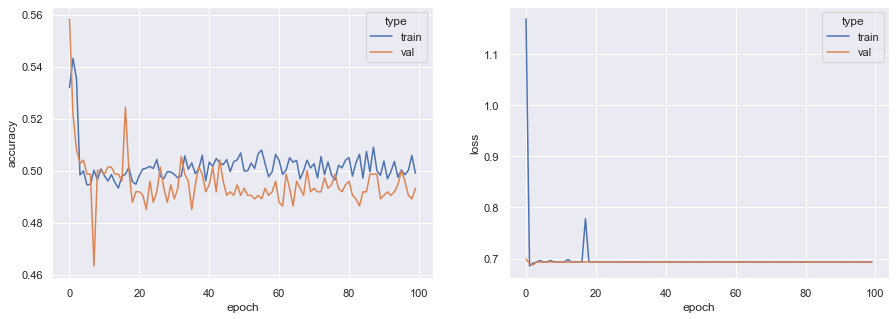

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
plt.show()

### Predicción de datos de prueba